In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from prefect import Flow, Parameter
import pandas as pd
from prefect.engine.executors import DaskExecutor

In [4]:
input_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")

In [11]:
from ml_flow import *
with Flow("data_cleaning") as flow:
    input_data = Parameter("input_data")
    problem, target, features = Parameter("problem"), Parameter("target"), Parameter("features")
    train_valid_split = extract_train_valid_split(input_data = input_data, problem = problem, target = target)
    train_data = extract_train_data(train_valid_split)
    valid_data = extract_valid_data(train_valid_split)
    nan_features = extract_nan_features(input_data)
    problematic_features = extract_problematic_features(input_data)
    undefined_features = extract_undefined_features(input_data, features, target,nan_features,problematic_features)
    
    numeric_features = extract_numeric_features(input_data,undefined_features)
    categorical_features = extract_categorical_features(input_data,undefined_features)
    missing_indicator = fit_missing_indicator(train_data,undefined_features)
    
    train_transformed_missing = transform_missing_indicator_df(train_data, undefined_features,missing_indicator)
    valid_transformed_missing = transform_missing_indicator_df(valid_data,undefined_features,missing_indicator)
    
    #numeric columns work
    numeric_imputer = fit_numeric_imputer(train_data,numeric_features)
    imputed_train_numeric_df = impute_numeric_df(numeric_imputer,train_data,numeric_features)
    imputed_valid_numeric_df = impute_numeric_df(numeric_imputer,valid_data,numeric_features)
    
    yeo_johnson_transformer = fit_yeo_johnson_transformer(imputed_train_numeric_df)
    yeo_johnson_train_transformed = transform_yeo_johnson_transformer(imputed_train_numeric_df,yeo_johnson_transformer)
    yeo_johnson_valid_transformed = transform_yeo_johnson_transformer(imputed_valid_numeric_df,yeo_johnson_transformer)
    
    #categorical columns work
    categorical_imputer = fit_categorical_imputer(train_data,categorical_features)
    imputed_train_categorical_df = transform_categorical_data(train_data,categorical_features,categorical_imputer)
    imputed_valid_categorical_df = transform_categorical_data(valid_data,categorical_features,categorical_imputer)
    
    target_transformer = fit_target_transformer(problem,target,train_data)
    transformed_train_target = transform_target(problem,target,train_data,target_transformer)
    transformed_valid_target = transform_target(problem,target,valid_data,target_transformer)
    
    target_encoder_transformer = fit_target_encoder(imputed_train_categorical_df,transformed_train_target)
    target_encoded_train_df = target_encoder_transform(target_encoder_transformer,imputed_train_categorical_df)
    target_encoded_valid_df = target_encoder_transform(target_encoder_transformer,imputed_valid_categorical_df)
    
    #merge_data
    transformed_train_df = merge_transformed_data(target_encoded_train_df, yeo_johnson_train_transformed,train_transformed_missing)
    transformed_valid_df = merge_transformed_data(target_encoded_valid_df, yeo_johnson_valid_transformed, valid_transformed_missing)
    
    #outlierness
    hbos_transformer = fit_hbos_transformer(transformed_train_df)
    hbos_transform_train_data = hbos_transform(transformed_train_df,hbos_transformer)
    hbos_transform_valid_data = hbos_transform(transformed_valid_df,hbos_transformer)
    
    #merge outlierness
    transformed_train_df = merge_hbos_df(transformed_train_df,hbos_transform_train_data)
    transformed_valid_df = merge_hbos_df(transformed_valid_df,hbos_transform_valid_data)
    
    #predictions
    create_prediction_db(problem,target)
    baseline_prediction(valid_data, target, train_data, transformed_valid_df, problem)



In [12]:
executor = DaskExecutor()
flow_state = flow.run(
    input_data= input_df, 
    problem="regression", 
    target = "SalePrice", 
    features = "infer",
    executor=executor
)

[2020-02-18 04:45:22,719] INFO - prefect.FlowRunner | Beginning Flow run for 'data_cleaning'
[2020-02-18 04:45:22,720] INFO - prefect.FlowRunner | Starting flow run.
[2020-02-18 04:45:22,860] INFO - prefect.TaskRunner | Task 'input_data': Starting task run...
[2020-02-18 04:45:22,898] INFO - prefect.TaskRunner | Task 'input_data': finished task run for task with final state: 'Success'
[2020-02-18 04:45:23,060] INFO - prefect.TaskRunner | Task 'features': Starting task run...
[2020-02-18 04:45:23,075] INFO - prefect.TaskRunner | Task 'extract_nan_features': Starting task run...
[2020-02-18 04:45:23,084] INFO - prefect.TaskRunner | Task 'features': finished task run for task with final state: 'Success'
[2020-02-18 04:45:23,092] INFO - prefect.TaskRunner | Task 'target': Starting task run...
[2020-02-18 04:45:23,113] INFO - prefect.TaskRunner | Task 'extract_nan_features': finished task run for task with final state: 'Success'
[2020-02-18 04:45:23,197] INFO - prefect.TaskRunner | Task 'ta

[2020-02-18 04:45:26,925] INFO - prefect.TaskRunner | Task 'hbos_transform': Starting task run...
[2020-02-18 04:45:26,928] INFO - prefect.TaskRunner | Task 'hbos_transform': Starting task run...
[2020-02-18 04:45:26,933] INFO - prefect.TaskRunner | Task 'hbos_transform': finished task run for task with final state: 'Success'
[2020-02-18 04:45:26,937] INFO - prefect.TaskRunner | Task 'hbos_transform': finished task run for task with final state: 'Success'
[2020-02-18 04:45:26,946] INFO - prefect.TaskRunner | Task 'merge_hbos_df': Starting task run...
[2020-02-18 04:45:26,956] INFO - prefect.TaskRunner | Task 'merge_hbos_df': Starting task run...
[2020-02-18 04:45:26,959] INFO - prefect.TaskRunner | Task 'merge_hbos_df': finished task run for task with final state: 'Success'
[2020-02-18 04:45:26,961] INFO - prefect.TaskRunner | Task 'merge_hbos_df': finished task run for task with final state: 'Success'
[2020-02-18 04:45:26,972] INFO - prefect.TaskRunner | Task 'baseline_prediction': St

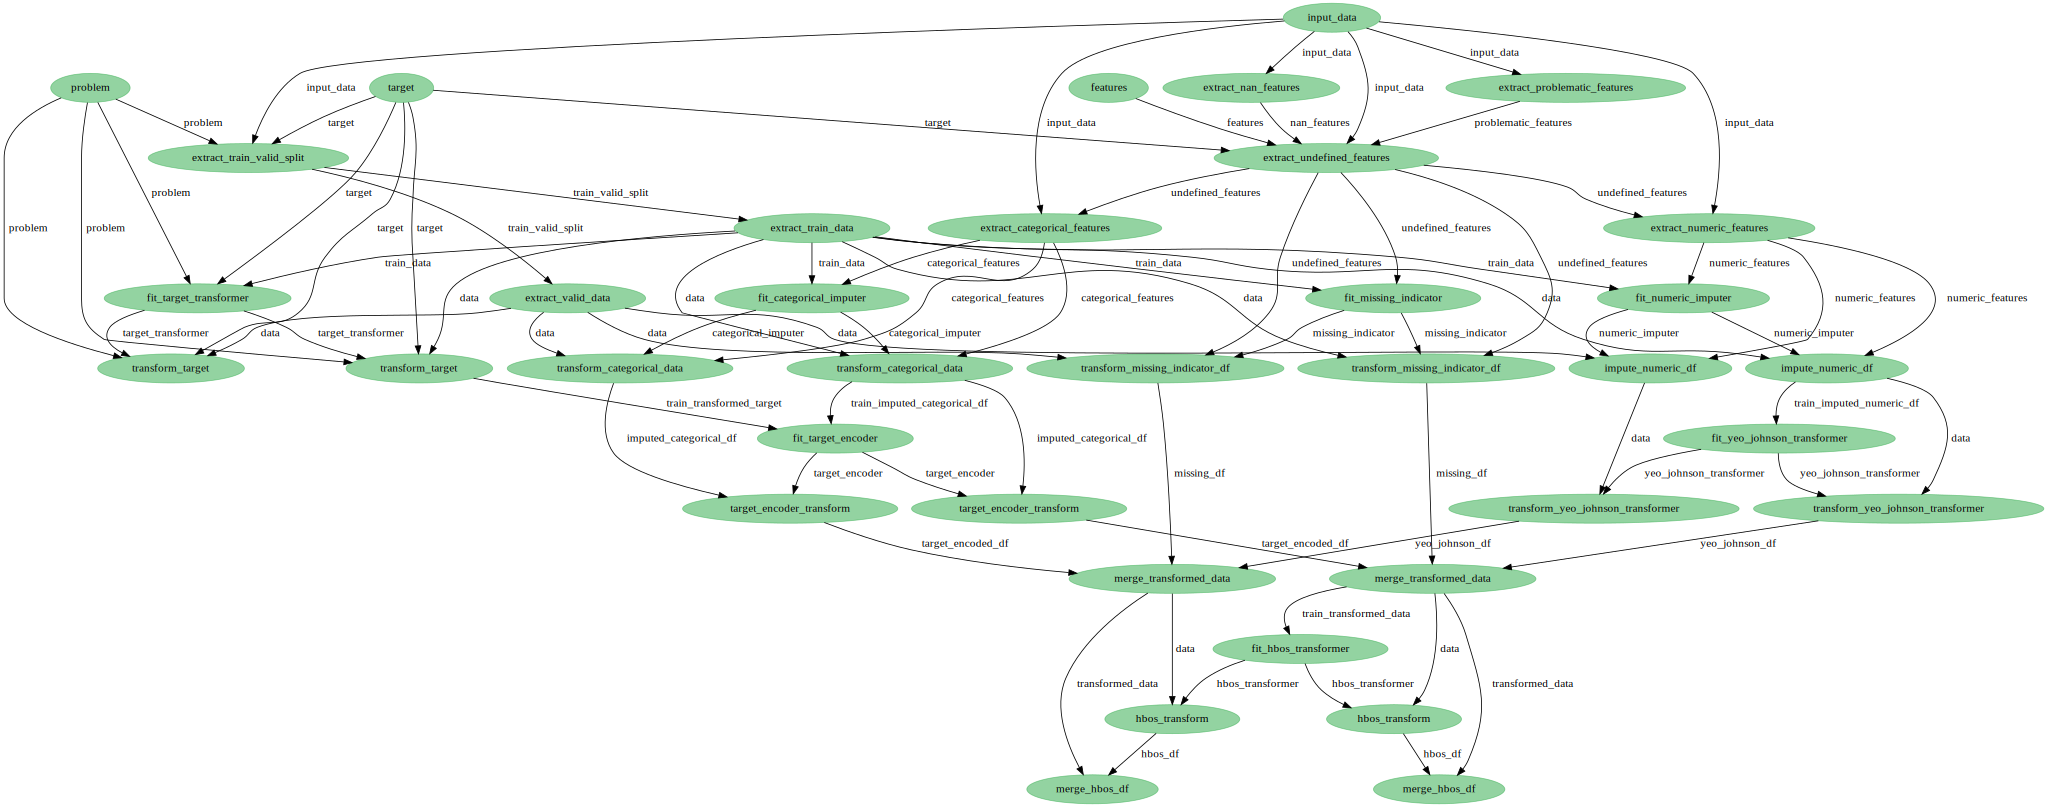

In [7]:
flow.visualize(flow_state=flow_state)